In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
from copy import deepcopy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
is_training_needed = False
model_name = "LeNet" # valid values: LeNet, ResNet
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [4]:
# Load MNIST data
def load_mnist(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST(root='./data', train=True, 
                                   download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, 
                                  download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                            shuffle=False, num_workers=2)
    
    return train_loader, test_loader

# Load data
BATCH_SIZE = 128
print("\n..... Loading MNIST dataset...")
train_loader, test_loader = load_mnist(BATCH_SIZE)
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


..... Loading MNIST dataset...
Training samples: 60000
Test samples: 10000


In [5]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x, mode=None,pp=False,c=(1,1,1,1)):
        x = self.pool(self.relu(self.conv1(x)))
        #layer 1
        #print("hahahahahhahahahahhahahh!!!!!!!!!!!!!!!!")
        if pp:
            print(x.shape)
        if mode=="compress":
            x=compress(x,c[0])
        x = self.pool(self.relu(self.conv2(x)))
        #layer 2
        if pp:
            print(x.shape)
        if mode=="compress":
            x=compress(x,c[1])
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        #layer 3
        if pp:
            print(x.shape)
        if mode=="compress":
            x=compress(x,c[2])
        x = self.relu(self.fc2(x))
        #layer 4
        if pp:
            print(x.shape)
        if mode=="compress":
            x=compress(x,c[3])
        x = self.fc3(x)
        if mode=="Test":
            print("LeNet Forward Testing !!!!!!!!!")
        #sys.exit()
        return x

In [6]:
def compress(x,c):
    if c==1:
        return x
    

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x, mode=None):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        if mode=="Test":
            print("ResidualBlock Forward Testing !!!!!!!!!")
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(16, 16, 2, stride=1)
        self.layer2 = self._make_layer(16, 32, 2, stride=2)
        self.layer3 = self._make_layer(32, 64, 2, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)
    
    def forward(self, x, mode=None):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        if mode=="Test":
            print("ResNet Forward Testing !!!!!!!!!")
        return x

In [9]:
def train_model(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [10]:
def evaluate_model(model, test_loader, criterion, mode=None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data, mode)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc

In [11]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['test_loss'], label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax2.plot(history['test_acc'], label='Test Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    print(f'Saved training history plot: {model_name}_training_history.png')
    plt.show()

In [12]:
def initial_training(model_name):
    if model_name == 'LeNet': 
        model = LeNet(num_classes=10)
    else:
        model = ResNet(num_classes=10)

        print(f"....... Training {model_name}")

    # Initialize model
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    # Training loop
    print(f"\nTraining {model_name} for {NUM_EPOCHS} epochs...")
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_model(model, train_loader, criterion, 
                                            optimizer, epoch)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion)
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f'\nEpoch {epoch}/{NUM_EPOCHS}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%')

    # Final evaluation
    print(f"\n...... Final Evaluation for {model_name}...")
    final_test_loss, final_test_acc = evaluate_model(model, test_loader, criterion)
    print(f"{model_name} - FINAL RESULTS")
    print(f"{'=' * 60}")
    print(f"Final Test Loss: {final_test_loss:.4f}")
    print(f"Final Test Accuracy: {final_test_acc:.2f}%")

    # Save model
    print(f"\n..... Saving {model_name} model...")
    torch.save({
        'epoch': NUM_EPOCHS,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'test_loss': final_test_loss,
        'test_acc': final_test_acc,
        'history': history
    }, f'{model_name}_mnist.pth')
    print(f"Model saved as: {model_name}_mnist.pth")

    # Plot training history
    print(f"\n....... Plotting training history for {model_name}...")
    plot_history(history, model_name)

In [13]:
def load_model(model_path, model_type='LeNet', device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Loading {model_type} model from {model_path}...")
    
    # Initialize the model architecture
    if model_type == 'LeNet':
        model = LeNet(num_classes=10)
    elif model_type == 'ResNet':
        model = ResNet(num_classes=10)
    else:
        raise ValueError(f"Unknown model type: {model_type}. Use 'LeNet' or 'ResNet'")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()  # Set to evaluation mode
    
    print(f"✓ Model loaded successfully!")
    print(f"  - Trained for {checkpoint['epoch']} epochs")
    print(f"  - Test Accuracy: {checkpoint['test_acc']:.2f}%")
    print(f"  - Test Loss: {checkpoint['test_loss']:.4f}")
    
    # checkpoint: Dictionary containing training history and metrics
    return model, checkpoint

In [21]:

if is_training_needed: 
    initial_training(model_name)

In [15]:
def test_loaded_model(model_path, model_type='LeNet', mode=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the model
    model, checkpoint = load_model(model_path, model_type, device)
    
    # Load test data
    #_, test_loader = load_mnist(batch_size=128)
    
    # Evaluate the loaded model
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, mode)
    
    print(f"\nVerification Test:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.2f}%")
    
    # Access training history if needed
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"\nTraining History Available:")
        print(f"  - Number of epochs: {len(history['train_loss'])}")
        print(f"  - Best train accuracy: {max(history['train_acc']):.2f}%")
        print(f"  - Best test accuracy: {max(history['test_acc']):.2f}%")
    
    return model, checkpoint

In [16]:


model_filename = f'{model_name}_mnist.pth'
print("\n------TESTING MODEL -------\n")

lenet_model, lenet_checkpoint = test_loaded_model(model_filename, model_name, mode="Test")


------TESTING MODEL -------

Loading LeNet model from LeNet_mnist.pth...


C:\Users\costa\AppData\Local\Temp\ipykernel_22572\2664528886.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✓ Model loaded successfully!
  - Trained for 10 epochs
  - Test Accuracy: 99.07%
  - Test Loss: 0.0281


Evaluating:   1%|▏         | 1/79 [00:14<18:22, 14.13s/it]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:   8%|▊         | 6/79 [00:14<02:08,  1.76s/it]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  14%|█▍        | 11/79 [00:14<00:54,  1.24it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  19%|█▉        | 15/79 [00:14<00:33,  1.94it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  27%|██▋       | 21/79 [00:15<00:16,  3.52it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  34%|███▍      | 27/79 [00:15<00:08,  6.13it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  38%|███▊      | 30/79 [00:15<00:06,  7.66it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  42%|████▏     | 33/79 [00:15<00:04,  9.42it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  51%|█████     | 40/79 [00:15<00:02, 14.06it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  56%|█████▌    | 44/79 [00:16<00:02, 16.77it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  65%|██████▍   | 51/79 [00:16<00:01, 21.16it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  73%|███████▎  | 58/79 [00:16<00:00, 24.94it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  77%|███████▋  | 61/79 [00:16<00:00, 23.26it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  85%|████████▍ | 67/79 [00:17<00:00, 22.76it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  92%|█████████▏| 73/79 [00:17<00:00, 23.03it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating:  97%|█████████▋| 77/79 [00:17<00:00, 24.96it/s]

LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!
LeNet Forward Testing !!!!!!!!!


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.26it/s]


Verification Test:
  Test Loss: 0.0281
  Test Accuracy: 99.07%

Training History Available:
  - Number of epochs: 10
  - Best train accuracy: 99.31%
  - Best test accuracy: 99.07%


In [17]:
# Weight masking function
def mask_layer_weights(model, layer_name, compression_ratio):
    """
    Mask weights by magnitude:
    - For Conv layers: mask entire output channels (kernels) by their L1 norm
    - For Linear layers: mask individual weights by magnitude
    """
    model_copy = deepcopy(model)
    
    # Get the layer
    layer = dict(model_copy.named_modules())[layer_name]
    
    if hasattr(layer, 'weight'):
        weights = layer.weight.data
        
        if isinstance(layer, nn.Conv2d):
            # For conv layers: mask entire output channels
            # weights shape: [out_channels, in_channels, kernel_h, kernel_w]
            num_channels = weights.shape[0]
            
            # Calculate L1 norm for each output channel
            channel_norms = torch.sum(torch.abs(weights), dim=(1, 2, 3))
            
            # Calculate how many channels to prune
            num_to_prune = int(num_channels * compression_ratio / 100)
            
            # Find threshold
            sorted_norms = torch.sort(channel_norms)[0]
            threshold = sorted_norms[num_to_prune] if num_to_prune < num_channels else sorted_norms[-1]
            
            # Create mask for channels
            mask = (channel_norms >= threshold).float()
            
            # Apply mask to all weights in each channel
            for i in range(num_channels):
                layer.weight.data[i] *= mask[i]
            
            # Also mask bias if it exists
            if layer.bias is not None:
                layer.bias.data *= mask
                
        elif isinstance(layer, nn.Linear):
            # For linear layers: mask individual weights by magnitude
            weight_magnitude = torch.abs(weights).flatten()
            
            # Calculate threshold
            num_weights = weight_magnitude.numel()
            num_to_prune = int(num_weights * compression_ratio / 100)
            
            # Find threshold value
            sorted_weights = torch.sort(weight_magnitude)[0]
            threshold = sorted_weights[num_to_prune] if num_to_prune < num_weights else sorted_weights[-1]
            
            # Create mask
            mask = (torch.abs(weights) >= threshold).float()
            layer.weight.data *= mask
    
    return model_copy

In [26]:
# Plotting function for layer compression analysis
def plot_layer_compression(model, layer_names, model_name):
    compression_ratios = [0, 20, 40, 60, 80, 90, 95]
    results = {}
    criterion = nn.CrossEntropyLoss()
    mode=None
    bloss,baseline_acc = evaluate_model(model, test_loader, criterion, mode)
    print(f"\n{model_name} - Baseline Accuracy: {baseline_acc:.2f}%")
    
    for layer_name in layer_names:
        accuracies = []
        print(f"\nAnalyzing {layer_name}:")
        
        for ratio in compression_ratios:
            masked_model = mask_layer_weights(model, layer_name, ratio)

            loss,acc = evaluate_model(masked_model, test_loader, criterion, mode)
            accuracies.append(acc)
            print(f"  Compression {ratio}%: {acc:.2f}%")
        
        results[layer_name] = accuracies
    
    # Plotting
    plt.figure(figsize=(10, 6))
    for layer_name, accuracies in results.items():
        plt.plot(compression_ratios, accuracies, marker='o', label=layer_name, linewidth=2)
    
    plt.xlabel('Compression Ratio (%)', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title(f'{model_name} - Accuracy vs Weight Compression by Layer', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=baseline_acc, color='r', linestyle='--', alpha=0.5, label='Baseline')
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_")}_compression.png', dpi=300)
    plt.show()
    
    return results


Analyzing lenet_model layers...


Evaluating: 100%|██████████| 79/79 [00:32<00:00,  2.40it/s]



lenet_model - Baseline Accuracy: 99.07%

Analyzing conv1:


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]


  Compression 0%: 99.07%


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.01it/s]


  Compression 20%: 98.89%


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


  Compression 40%: 97.77%


Evaluating: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]


  Compression 60%: 70.39%


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.09it/s]


  Compression 80%: 72.66%


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.84it/s]


  Compression 90%: 30.30%


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


  Compression 95%: 30.30%

Analyzing conv2:


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.58it/s]


  Compression 0%: 99.07%


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


  Compression 20%: 98.28%


Evaluating: 100%|██████████| 79/79 [00:19<00:00,  4.14it/s]


  Compression 40%: 95.54%


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.79it/s]


  Compression 60%: 81.03%


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


  Compression 80%: 72.07%


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.50it/s]


  Compression 90%: 54.98%


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]


  Compression 95%: 21.03%

Analyzing fc1:


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.14it/s]


  Compression 0%: 99.07%


Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.93it/s]


  Compression 20%: 99.05%


Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


  Compression 40%: 98.99%


Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.84it/s]


  Compression 60%: 98.97%


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.76it/s]


  Compression 80%: 98.71%


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]


  Compression 90%: 95.37%


Evaluating: 100%|██████████| 79/79 [00:21<00:00,  3.61it/s]


  Compression 95%: 84.22%

Analyzing fc2:


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.41it/s]


  Compression 0%: 99.07%


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.31it/s]


  Compression 20%: 99.07%


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


  Compression 40%: 99.00%


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.27it/s]


  Compression 60%: 98.93%


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.52it/s]


  Compression 80%: 98.90%


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


  Compression 90%: 97.76%


Evaluating: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


  Compression 95%: 90.46%

Analyzing fc3:


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.32it/s]


  Compression 0%: 99.07%


Evaluating: 100%|██████████| 79/79 [00:24<00:00,  3.28it/s]


  Compression 20%: 99.02%


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


  Compression 40%: 98.85%


Evaluating: 100%|██████████| 79/79 [00:27<00:00,  2.85it/s]


  Compression 60%: 97.28%


Evaluating: 100%|██████████| 79/79 [00:27<00:00,  2.86it/s]


  Compression 80%: 95.59%


Evaluating: 100%|██████████| 79/79 [00:26<00:00,  3.03it/s]


  Compression 90%: 79.39%


Evaluating: 100%|██████████| 79/79 [00:25<00:00,  3.09it/s]


  Compression 95%: 61.67%


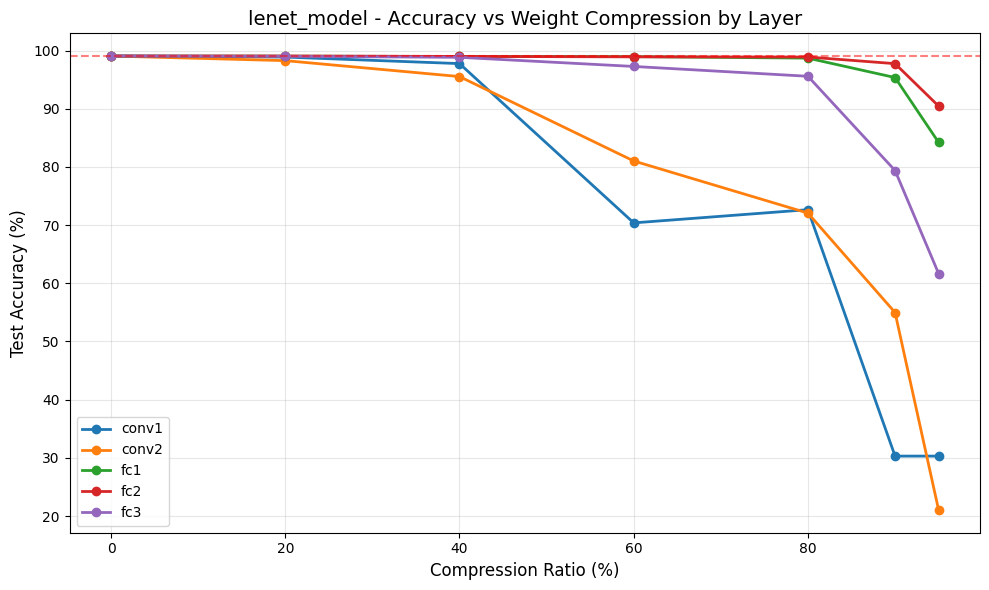

In [27]:
# Analyze layers
print("\n" + "="*50)
print("Analyzing lenet_model layers...")
print("="*50)
simple_layers = ['conv1', 'conv2', 'fc1', 'fc2','fc3']
results1 = plot_layer_compression(lenet_model, simple_layers, "lenet_model")

In [22]:
# Analyze layers
print("\n" + "="*50)
print("Analyzing lenet_model layers...")
print("="*50)
simple_layers = ['conv1', 'conv2', 'fc1', 'fc2','fc3']
results1 = plot_layer_compression(lenet_model, simple_layers, "lenet_model")




Analyzing lenet_model layers...


TypeError: evaluate_model() missing 2 required positional arguments: 'test_loader' and 'criterion'